In [1]:
globalseed = 0

In [2]:
masscut = 10**9

# Basic settings

### Settings that define the different runs

Each cell contains one run settings. These should all be coded as "Raw NBConvert" cells. The wrapper function will pull out the appropriate settings and run the full notebook, and finally save the output as a separate Jupyter notebook.

In [3]:
runname = "ComparisonModel"

FullModelPredsUse = ['log galaxy_mass','log sigma_v','rband Mag','gband Mag','iband Mag',
            'zband Mag',
            'log SubhaloSFR', 'SubhaloSFRZero','central_bool','mc_disk',
            'log delta3d_smooth_real_0.5', 'log delta3d_smooth_real_1.0',
            'log delta3d_smooth_real_2.0','log delta3d_smooth_real_5.0']

PredsOnlyInFull = ['log galaxy_mass','log sigma_v',
            'log SubhaloSFR', 'SubhaloSFRZero','central_bool','mc_disk',
            'log delta3d_smooth_real_0.5', 'log delta3d_smooth_real_1.0',
            'log delta3d_smooth_real_2.0','log delta3d_smooth_real_5.0']

PredsFullTest = ['log galaxy_mass','log sigma_v',
            'log SubhaloSFR', 'SubhaloSFRZero','mc_disk',
            'log delta3d_smooth_real_0.5', 'log delta3d_smooth_real_1.0',
            'log delta3d_smooth_real_2.0','log delta3d_smooth_real_5.0',
            'rband Mag','gband Mag','iband Mag','zband Mag','delta_smooth_R']

ObsPredsUse = ['rband Mag','gband Mag','iband Mag','zband Mag','delta_smooth_R','mc_disk']
#ObsPredsUse = ['rband Mag','gband Mag','iband Mag','zband Mag']
#ObsPredsUse = ['g - r','r - i','i - z']


#ObsPredsUse = ['gband Mag', 'g - r', 'r - i','i - z']

FullModelPredsUse = PredsOnlyInFull + ObsPredsUse

FullModelRespUse = 'log size'

predsscl = ['rband Mag','gband Mag','iband Mag','zband Mag','log SubhaloSFR','log sigma_v','log galaxy_mass','mc_disk',
            'log delta3d_smooth_real_0.5', 'log delta3d_smooth_real_1.0',
            'log delta3d_smooth_real_2.0','log delta3d_smooth_real_5.0','delta_smooth_R']

predsscl = PredsFullTest

predsscl = []

In [4]:
file_dir='./temp/ChadAnalyses/'+runname+'/'

This is the end of settings cells.

### Settings that are fixed across runs

In [5]:
traintestseed = globalseed

In [6]:
# This controls the number of projection functions in the PPR

ruse = 1

epochs=500

learning_rate = 0.001

decay_rate = learning_rate / epochs

momentum = 0.8

These are the "quick" settings. They are designed to allow the user to more rapidly verify that there are not bugs in the setup.

# Import Packages

In [7]:
%pylab inline

import illustris_python as il
import pandas as pd
import pickle

import os

from astropy.table import Table

from matplotlib.colors import LogNorm

import random

from skpp import ProjectionPursuitRegressor

Populating the interactive namespace from numpy and matplotlib


In [8]:
%run ./FullPPR.ipynb

In [9]:
#from numpy.random import seed
np.random.seed(globalseed)

In [10]:
basePath= '/hildafs/datasets/IllustrisTNG/TNG100-1/output'
snapNum=99 #refers to final snapshot, redshift of zero

# Create the combined catalog

Start with data from the base Illustris catalog.

See https://www.tng-project.org/data/docs/specifications/#sec2b

These are the fields that will be extracted from this catalog.

In [11]:
addvariables = ['SubhaloBHMass','SubhaloGasMetallicity','SubhaloSFR',
                'SubhaloStarMetallicity','SubhaloVmax']

In [12]:
fields = ['SubhaloGrNr',
          'SubhaloFlag',
          'SubhaloMassType',
          'SubhaloPos',
          'SubhaloStellarPhotometrics',
          'SubhaloMassInHalfRad',
          'SubhaloHalfmassRad',
          'SubhaloHalfmassRadType'] + addvariables

In [13]:
subhalos=il.groupcat.loadSubhalos(basePath,snapNum,fields=fields)

This is here just for reference:

0. PartType0 - GAS
1. PartType1 - DM
2. PartType2 - (unused)
3. PartType3 - TRACERS
4. PartType4 - STARS & WIND PARTICLES
5. PartType5 - BLACK HOLES

### Read in additional catalogs

THIS SEEMS TO BE UNNECESSARY. EVERYTHING IN HERE APPEARS TO BE IN THE FULL CATALOG BELOW.
The shape catalog. Note that this catalog already comes in with a mass cut of `10**10 M_sun`.

In [14]:
#df_non_red_100_subfind_shapes = pd.DataFrame(
#    pickle.load(open('/hildafs/datasets/IllustrisTNG/TNG100-1/df_non_red_100_subfind_mass-cut10', "rb" ) ))
#df_non_red_100_subfind_shapes.shape

The velocity dispersion catalog.

In [15]:
df_non_red_100_subfind_sigma_v = pd.DataFrame(pickle.load(
    open('/hildafs/datasets/IllustrisTNG/TNG100-1/TNG100-1_99_galaxy_vel_disp_100.0.p', 
         "rb" ) ))

print(df_non_red_100_subfind_sigma_v.shape)
df_non_red_100_subfind_sigma_v.head()

(20051, 5)


,gal_id,Lx,Ly,Lz,sigma_v
0,0.0,-9.085662,-7.872045,-4.559502,374.378662
1,1.0,1.795185,-0.857926,1.563985,214.005508
2,2.0,0.620052,2.585010,0.742175,196.719849
3,3.0,0.292968,-0.387597,-1.368885,106.750359
4,4.0,-0.058817,0.112009,-0.858557,116.125282


Density information.

In [16]:
galdens = pickle.load(open('galdens.p', 'rb'))

The "full" catalog.

In [17]:
df_non_red_100_subfind_full = pickle.load(
    open('/hildafs/datasets/IllustrisTNG/TNG100-1/TNG100-1_99_galaxy_component_shapes_3I_subfind_FULL_mass-cut9.p', 
         "rb" ) )

print(df_non_red_100_subfind_full.shape)
df_non_red_100_subfind_full.head()

(20051, 114)


,gal_id,f_disk,int_disk_thin,int_disk_thick,int_disk_counter_exp2,chisq_exp2,int_disk_exp1,int_disk_counter_exp1,chisq_exp1,mc_disk,...,bv_z,cv_x,cv_y,cv_z,mass,gal_pos_x,gal_pos_y,gal_pos_z,e1,e2
0,0.0,0.102826,1.120683e-11,0.252965,0.090781,69.553006,0.359817,0.198626,54.325447,0.229510,...,0.377225,0.782535,0.612006,0.114402,3.705585e+12,0.849091,26.326996,18.306934,-0.109703,-0.157248
1,1.0,0.073827,5.167568e-03,0.082322,0.064100,287.146480,0.208253,0.173610,272.848191,0.084007,...,0.469768,-0.159400,0.476258,-0.864737,5.587917e+11,0.106473,24.633322,16.900553,0.295580,0.009956
2,2.0,0.104297,5.651366e-02,0.208010,0.100389,63.551982,0.203645,0.071742,77.861395,0.237992,...,-0.293690,0.135702,0.904910,0.403390,6.271396e+11,0.853112,26.725748,17.510679,0.026402,-0.016790
3,3.0,0.293960,3.609416e-01,0.187110,0.037387,72.289555,0.448154,0.028169,967.551351,0.564971,...,-0.012360,-0.111798,0.556926,0.823003,1.715515e+11,0.245455,26.517372,15.888749,-0.066341,-0.033003
4,4.0,0.158796,7.771672e-02,0.102280,0.022292,72.560206,0.135537,0.005955,184.095625,0.199667,...,0.015853,-0.002944,-0.163988,0.986458,1.333404e+11,0.768784,26.518290,15.530523,-0.028562,0.007162


Note that, for some reason, `gal_id` appears twice in the "full" catalog. Hence, the `drop` function removes both of those instances. It's for this reason that I am dropping from the "full" catalog, and not from the velocity dispersion catalog.

In [18]:
fullinfo = pd.concat(
    [df_non_red_100_subfind_full.drop({'gal_id'},axis=1),
     df_non_red_100_subfind_sigma_v,
     galdens], 
     axis=1)

### Create the merged catalog

For each variable in the base catalog, need to extract the elements based on `gal_id` in the supplemental catalog.

The photometric magnitudes.

In [19]:
fullinfo['gband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),4]
fullinfo['rband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),5]
fullinfo['iband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),6]
fullinfo['zband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),7]

Colors

In [20]:
fullinfo['g - r'] = fullinfo['gband Mag'] - fullinfo['rband Mag']
fullinfo['r - i'] = fullinfo['rband Mag'] - fullinfo['iband Mag']
fullinfo['i - z'] = fullinfo['iband Mag'] - fullinfo['zband Mag']

Size and mass. (Mass measures stars.)

In [21]:
fullinfo['size'] = subhalos['SubhaloHalfmassRad'][fullinfo['gal_id'].astype('int')]
fullinfo['galaxy_mass'] = \
     subhalos['SubhaloMassType'][fullinfo['gal_id'].astype('int'),4]*10**10

Other variables from the base catalog.

In [22]:
for addvar in addvariables:
    fullinfo[addvar] = subhalos[addvar][fullinfo['gal_id'].astype('int')]

The subhalo flag is mapped over, in order to exclude flagged observations.

In [23]:
fullinfo['subhaloflag'] = subhalos['SubhaloFlag'][fullinfo['gal_id'].astype('int')]

There are some duplicated columns. Note that the data in them were not actually identical. In particular, the position variables were off by a factor of 1000.

In [24]:
fullinfo = fullinfo.loc[:,~fullinfo.columns.duplicated()]

Exclude any observations for which the `SubhaloFlag` is `False` or the mass is not sufficiently large. If mass cutoff is $10^9$, there should be 17513 rows remaining. If the mass cutoff is $10^{10}$, there should be 4987 rows remaining.

In [25]:
keep = (fullinfo['subhaloflag']) & (fullinfo['galaxy_mass'] > masscut) 
print(sum(keep))

subinfo = fullinfo[keep].copy()

17513


Create log-transformed versions of some variables.

In [26]:
varsToLogTransform = ['galaxy_mass',
                      'sigma_v',
                      'size','delta3d_smooth_real_0.1',
                      'delta3d_smooth_real_0.5',
                      'delta3d_smooth_real_1.0',
                      'delta3d_smooth_real_2.0',
                      'delta3d_smooth_real_5.0']

for varname in varsToLogTransform:
    subinfo['log ' + varname] = log10(subinfo[varname])

Some of the variables have a spike of values at zero, but are otherwise positive (and skewed). The strategy taken here is to create an indicator variable for zero values, and then log transform the positive values. Hence, there are two variables included in the model for each of these.

In [27]:
# SubhaloBHMassZero

subinfo['SubhaloBHMassZero'] = (subinfo['SubhaloBHMass'] == 0).astype(int)

subinfo['log SubhaloBHMass'] = \
   [0 if val == 0 else log10(val) for val in subinfo['SubhaloBHMass']]


# SubhaloSFR

subinfo['SubhaloSFRZero'] = (subinfo['SubhaloSFR'] == 0).astype(int)

subinfo['log SubhaloSFR'] = \
   [0 if val == 0 else log10(val) for val in subinfo['SubhaloSFR']]


# SubhaloGasMetallicity is not skewed

subinfo['SubhaloGasMetallicityZero'] = (subinfo['SubhaloGasMetallicity'] == 0).astype(int)


Create indicators for the different size bins.

In [28]:
holdQ = pd.qcut(subinfo['log size'],4,labels=["SizeQ1","SizeQ2","SizeQ3","SizeQ4"])

subinfo['SizeQ1'] = (holdQ == "SizeQ1").astype(int)
subinfo['SizeQ2'] = (holdQ == "SizeQ2").astype(int)
subinfo['SizeQ3'] = (holdQ == "SizeQ3").astype(int)
subinfo['SizeQ4'] = (holdQ == "SizeQ4").astype(int)

subinfo['small sigma_v'] = (subinfo['log sigma_v'] <-2).astype(int)

#subinfo = subinfo[subinfo['SizeQ4']==1]

These are the predicted values for central/satellite classifcation.

In [29]:
subinfo['CSpredsbyNN'] = pickle.load(open("CSpredsbyNN.p",'rb'))

In [30]:
subinfo['3Dcomb'] = subinfo['delta3d_smooth_real_0.1'] - 1.4*subinfo['delta3d_smooth_real_0.5'] + \
0.4*subinfo['delta3d_smooth_real_1.0']

## Set the response

In [31]:
respuse = 'log size'

## Scale Selected Predictors

In [32]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler(copy=True)

if(len(predsscl)>0):
    scaler.fit(subinfo[predsscl])
    foo = pd.DataFrame(scaler.transform(subinfo[predsscl]),columns=predsscl, index=subinfo.index)
    subinfo = pd.DataFrame.join(subinfo.drop(predsscl,axis=1),foo)

In [33]:
subinfo.head()

,f_disk,int_disk_thin,int_disk_thick,int_disk_counter_exp2,chisq_exp2,int_disk_exp1,int_disk_counter_exp1,chisq_exp1,mc_disk,a_simple_disk,...,SubhaloSFRZero,log SubhaloSFR,SubhaloGasMetallicityZero,SizeQ1,SizeQ2,SizeQ3,SizeQ4,small sigma_v,CSpredsbyNN,3Dcomb
0,0.102826,1.120683e-11,0.252965,0.090781,69.553006,0.359817,0.198626,54.325447,0.229510,0.263015,...,0,0.347757,0,0,0,0,1,0,0.142798,-800.735008
1,0.073827,5.167568e-03,0.082322,0.064100,287.146480,0.208253,0.173610,272.848191,0.084007,0.093535,...,0,-0.383750,0,0,0,0,1,0,0.153434,-100.536295
2,0.104297,5.651366e-02,0.208010,0.100389,63.551982,0.203645,0.071742,77.861395,0.237992,0.038423,...,0,1.240355,0,0,0,0,1,0,0.115919,-246.018807
3,0.293960,3.609416e-01,0.187110,0.037387,72.289555,0.448154,0.028169,967.551351,0.564971,0.017284,...,0,0.705811,0,0,0,0,1,0,0.081635,-84.596632
4,0.158796,7.771672e-02,0.102280,0.022292,72.560206,0.135537,0.005955,184.095625,0.199667,0.018827,...,0,0.150661,0,0,0,0,1,0,0.087160,-131.607632


## Split data

This will create a grid of pixels in (x,y,z) space.

It will be used to make the splits into the separate sets.

The entire data set needs to be divided into the following groups:
1. **Set 0**: The training set for learning the linear combinations of the full variable set that are useful for predicting the response
2. **Set 1** The training set for learning the relationship between those linear combinations and the magnitudes
3. **Set 2** The training set for learning the relationship between the mags and those predicted linear combinations and the log size
4. **Set 3** The final test set

The following sets the proportion of the cells that will be in each of the four sets.
**Note that due to pixelization, the proportions will not exactly equal these.**

In [34]:
propinset = [0.7, 0.2, 0.05, 0.05]

Divide the rows into pixels. The value of 'gridsize' determines how many pixels are in each direction, i.e., the total number of pixels is 'gridsize' cubed.

In [35]:
gridsize = 5

gx = np.linspace(min(subinfo['gal_pos_x']), max(subinfo['gal_pos_x']), gridsize+1)
gy = np.linspace(min(subinfo['gal_pos_y']), max(subinfo['gal_pos_y']), gridsize+1)
gz = np.linspace(min(subinfo['gal_pos_z']), max(subinfo['gal_pos_z']), gridsize+1)


# Assign to pixels

pixelnum = (subinfo['gal_pos_x'] >= gx[1]).astype(int)

for i in range(2,gridsize):
    pixelnum = pixelnum + (subinfo['gal_pos_x'] >= gx[i]).astype(int)
    
for i in range(1,gridsize):
    pixelnum = pixelnum + gridsize*(subinfo['gal_pos_y'] >= gy[i]).astype(int)
    
for i in range(1,gridsize):
    pixelnum = pixelnum + gridsize*gridsize*(subinfo['gal_pos_z'] >= gz[i]).astype(int)

subinfo['pixelnum'] = pixelnum

Randomly split the cells among the four sets. Note that the seed is set by `traintestseed`.

In [36]:
pixeldf = pd.crosstab(index=subinfo['pixelnum'], columns='count')
pixeldf = pixeldf.sample(frac=1,random_state=traintestseed)

pixeldf=pd.DataFrame({'pixelnum':list(pixeldf.index),'count':list(pixeldf['count'])})

In [37]:
pos = 0
pixeldf['Set'] = pixeldf['count']

totgals = subinfo.shape[0]
setnum = np.empty(totgals)

# Assign pixels to Sets

for setind in range(len(propinset)):
    galsinset = 0
    print('Target for Set:',propinset[setind])
    while(galsinset < (propinset[setind]*totgals) and pos < (gridsize**3)):
        pixeldf['Set'][pos] = setind
        galsinset = galsinset + pixeldf['count'][pos]
        setnum[subinfo['pixelnum'] == pixeldf['pixelnum'][pos]] = setind
        pos +=1
    
    print('Actual for Set:',round(galsinset/totgals,3))
    
subinfo['Set'] = setnum

Target for Set: 0.7
Actual for Set: 0.704
Target for Set: 0.2
Actual for Set: 0.201
Target for Set: 0.05
Actual for Set: 0.056
Target for Set: 0.05
Actual for Set: 0.039


## Dimension Reduction

In [38]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets

In [39]:
#subinfo[ObsPredsUse] = np.random.rand(subinfo[ObsPredsUse].shape[0],subinfo[ObsPredsUse].shape[1])

In [40]:
from sklearn.decomposition import KernelPCA,PCA
# initialize the Kernel PCA object
#Kernel_pca = KernelPCA(n_components = 20, kernel= "sigmoid", gamma=0.000001)

Kernel_pca = KernelPCA(n_components = 20, kernel= "sigmoid", gamma=0.001)
#Kernel_pca = PCA(n_components = 4)

# transform and fit the feature of the training set. Only use set 0 to fit the transform
fittotrainset = Kernel_pca.fit_transform(subinfo[subinfo['Set']==0][ObsPredsUse].astype(float))

Y = Kernel_pca.transform(subinfo[ObsPredsUse].astype(float))

#Y = Kernel_pca.fit_transform(subinfo[ObsPredsUse])

In [41]:
Y[subinfo['Set']==0,:]

array([[ 8.78033519e-04, -5.16403770e-04,  8.27894079e-06, ...,
         8.31936295e-07,  4.12278494e-07, -1.67176867e-08],
       [ 8.77650927e-04, -5.09643780e-04,  7.89675656e-06, ...,
        -2.85754251e-07, -6.25042223e-07, -1.34293851e-07],
       [ 8.78033482e-04, -5.16401422e-04,  8.27865335e-06, ...,
         8.13475995e-07,  4.04141844e-07, -1.64979603e-08],
       ...,
       [ 3.34319422e-03, -7.21338556e-04,  2.54377021e-04, ...,
        -3.41703328e-07,  3.35004777e-07, -5.58363369e-07],
       [ 2.98775463e-03, -3.64683754e-04,  1.71189579e-04, ...,
        -3.20312316e-07, -1.34166742e-07, -4.54125142e-08],
       [ 3.22718829e-03, -5.11374018e-04,  1.85425978e-04, ...,
        -4.09530939e-07, -1.47016928e-08,  5.63631252e-09]])

In [42]:
fittotrainset

array([[ 8.78033519e-04, -5.16403772e-04,  8.27894092e-06, ...,
         8.32591967e-07,  4.12806206e-07, -1.67656251e-08],
       [ 8.77650927e-04, -5.09643782e-04,  7.89675669e-06, ...,
        -2.85076000e-07, -6.24492918e-07, -1.34342894e-07],
       [ 8.78033482e-04, -5.16401423e-04,  8.27865348e-06, ...,
         8.14154540e-07,  4.04691395e-07, -1.65471108e-08],
       ...,
       [ 3.34319422e-03, -7.21338556e-04,  2.54377021e-04, ...,
        -3.41703229e-07,  3.35004792e-07, -5.58363365e-07],
       [ 2.98775463e-03, -3.64683754e-04,  1.71189579e-04, ...,
        -3.20312270e-07, -1.34166738e-07, -4.54125167e-08],
       [ 3.22718829e-03, -5.11374018e-04,  1.85425978e-04, ...,
        -4.09530937e-07, -1.47016908e-08,  5.63631077e-09]])

In [43]:
subinfo.drop(columns=[x for x in subinfo.columns if x.startswith('KPCA')],inplace=True, errors='ignore')

for i in range(Y.shape[1]):
    subinfo['KPCA'+str(i)] = Y[:,i]
    
NEWpreds = [x for x in subinfo.columns if x.startswith('KPCA')]

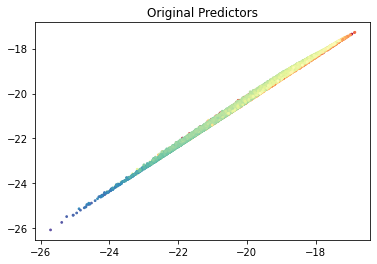

In [44]:
coluse = subinfo[FullModelRespUse]
plt.scatter(subinfo[ObsPredsUse].iloc[:, 0], subinfo[ObsPredsUse].iloc[:, 2], c=coluse, cmap=plt.cm.Spectral,s=3)
plt.title("Original Predictors")
plt.show()

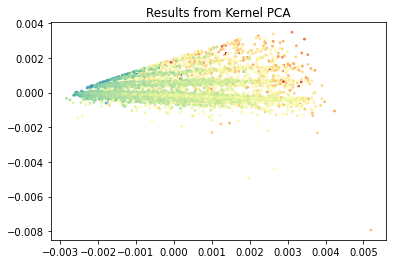

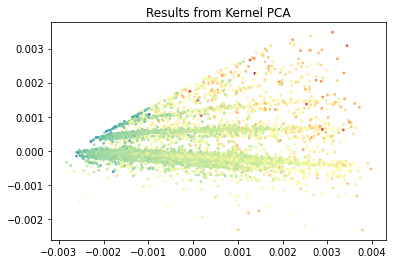

In [45]:
coluse = subinfo[FullModelRespUse]
plt.scatter(Y[:, 0], Y[:, 1], c=coluse, cmap=plt.cm.Spectral,s=3)
plt.title("Results from Kernel PCA")
plt.show()

plt.scatter(fittotrainset[:, 0], fittotrainset[:, 1], c=coluse[subinfo['Set']==0], cmap=plt.cm.Spectral,s=3)
plt.title("Results from Kernel PCA")
plt.show()

In [ ]:
train_features = subinfo[subinfo['Set']==0][ObsPredsUse]
train_labels = subinfo[subinfo['Set']==0][FullModelRespUse]

train_pixels = subinfo[subinfo['Set']==0]['pixelnum']

train_features = train_features.astype(float)

test_features = subinfo[subinfo['Set']>0][ObsPredsUse]
test_labels = subinfo[subinfo['Set']>0][FullModelRespUse]

test_features = test_features.astype(float)

rtry = [3,4,5,6,7,8,9,10,11,12]

FullPPR(train_features, train_labels, test_features, test_labels,
            train_pixels, rtry, runname='OrigModel',PredsNames=ObsPredsUse)

-----------------------------------------------
Histograms of Distributions of Each Predictor
-----------------------------------------------
Running Cross-Validation Procedure
[[3.         3.         0.07422808 0.07703199]]
[[3.         3.         0.07422808 0.07703199]
 [4.         3.         0.06748029 0.06970103]]
[[3.         3.         0.07422808 0.07703199]
 [4.         3.         0.06748029 0.06970103]
 [5.         3.         0.06437037 0.06585314]]
[[3.         3.         0.07422808 0.07703199]
 [4.         3.         0.06748029 0.06970103]
 [5.         3.         0.06437037 0.06585314]
 [6.         3.         0.06205065 0.06354138]]


In [46]:
scaler = preprocessing.StandardScaler(copy=True)
scaler.fit(subinfo[NEWpreds])
foo = pd.DataFrame(scaler.transform(subinfo[NEWpreds]),columns=NEWpreds, index=subinfo.index)
subinfo = pd.DataFrame.join(subinfo.drop(NEWpreds,axis=1),foo)

In [47]:
from scipy.stats import kurtosis

kurtosishold = numpy.zeros(len(NEWpreds))

print(kurtosishold)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


-0.46905370329076135


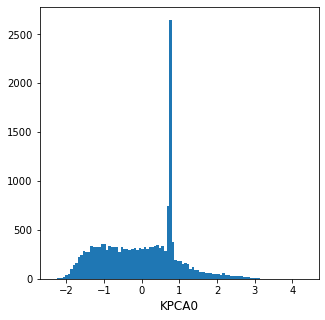

10.951017722879147


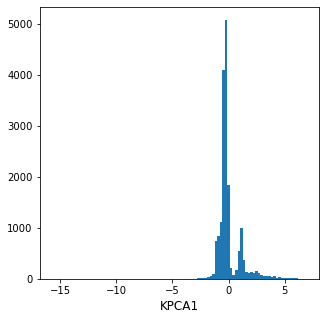

0.3376381121944161


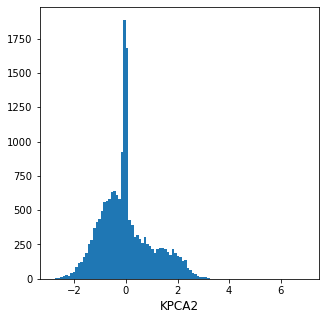

0.49923512273569814


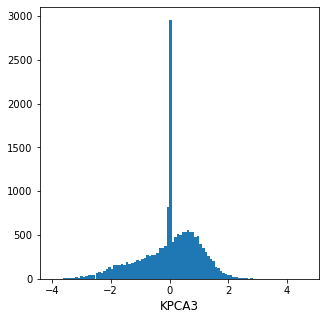

492.53248626138407


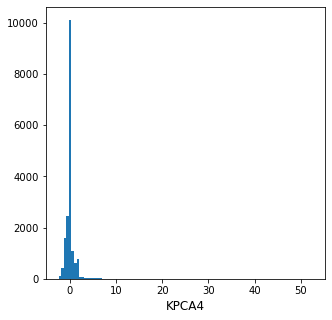

195.22020385627218


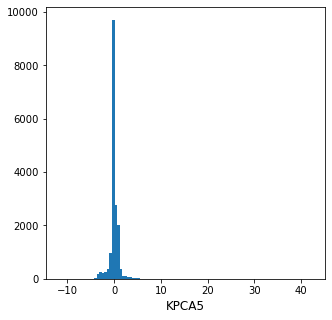

54.434127187232505


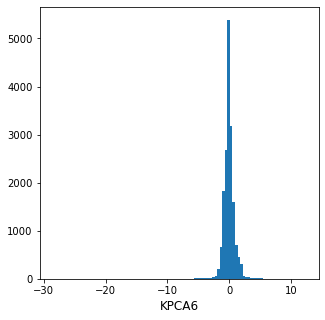

1.4884065074328108


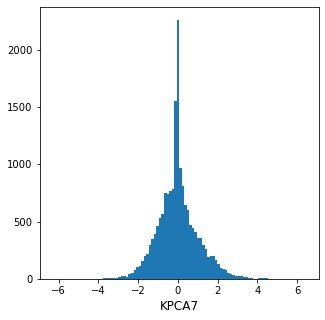

198.55226400726866


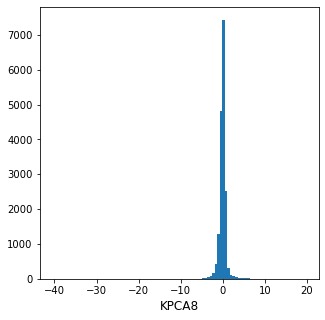

5252.951438705856


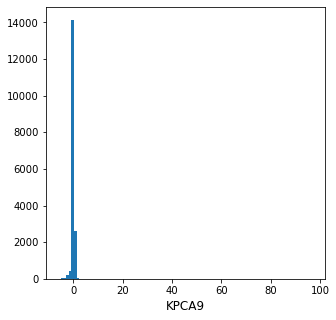

578.960656937988


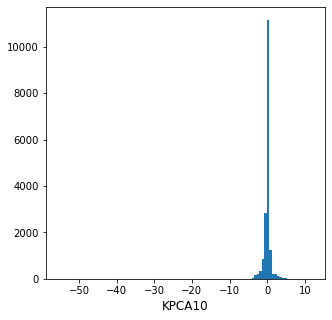

15.521878287286587


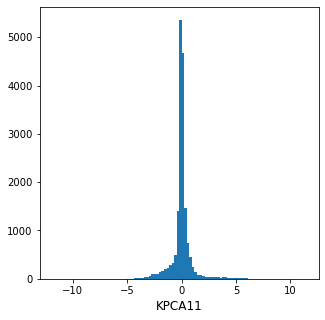

22.086220875611215


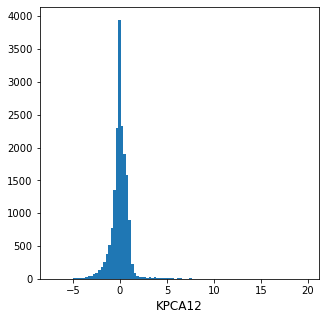

6315.118956082357


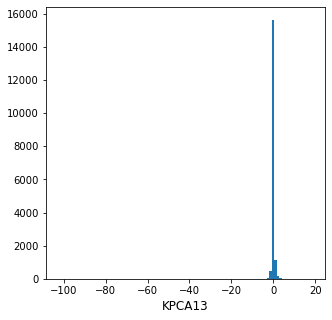

22.329113285060433


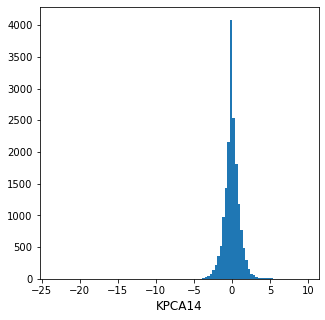

8.159037771407142


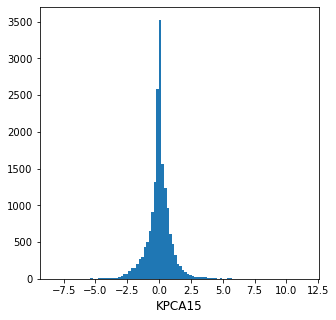

181.01785966030576


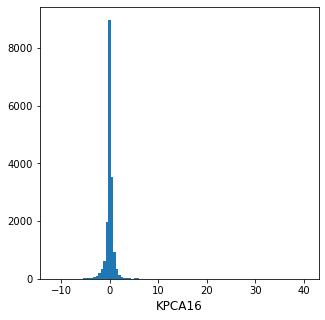

8771.49552942342


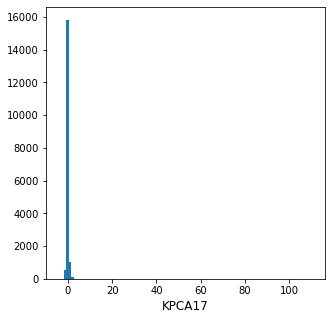

10570.232650413422


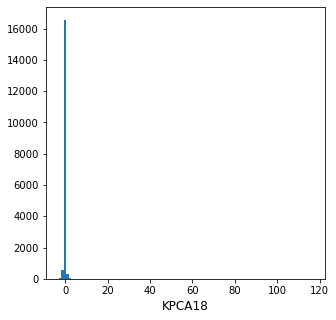

67.79883008070627


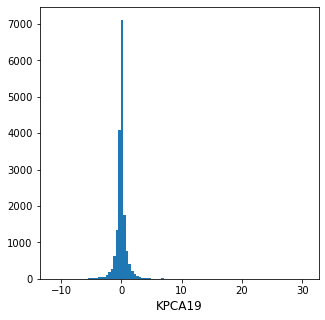

[-4.69053703e-01  1.09510177e+01  3.37638112e-01  4.99235123e-01
  4.92532486e+02  1.95220204e+02  5.44341272e+01  1.48840651e+00
  1.98552264e+02  5.25295144e+03  5.78960657e+02  1.55218783e+01
  2.20862209e+01  6.31511896e+03  2.23291133e+01  8.15903777e+00
  1.81017860e+02  8.77149553e+03  1.05702327e+04  6.77988301e+01]


In [48]:
pos = 0
for pred in NEWpreds:
    plt.figure(figsize=[5,5])
    hist(subinfo[pred], bins=100)
    kurtosishold[pos] = kurtosis(subinfo[pred])
    print(kurtosis(subinfo[pred]))
    plt.xlabel(pred,size=12)
    plt.show()
    pos +=1
print(kurtosishold)

In [49]:
NEWpreds2 = list(np.array(NEWpreds)[kurtosishold<100]) + ObsPredsUse

-----------------------------------------------
Histograms of Distributions of Each Predictor
-----------------------------------------------
Running Cross-Validation Procedure
[[3.         2.         0.06028295 0.06144881]]
[[3.         2.         0.06028295 0.06144881]
 [4.         2.         0.05730113 0.0583734 ]]
[[3.         2.         0.06028295 0.06144881]
 [4.         2.         0.05730113 0.0583734 ]
 [5.         2.         0.05799324 0.05932315]]
[[3.         2.         0.06028295 0.06144881]
 [4.         2.         0.05730113 0.0583734 ]
 [5.         2.         0.05799324 0.05932315]
 [6.         2.         0.05696087 0.05829368]]
[[3.         2.         0.06028295 0.06144881]
 [4.         2.         0.05730113 0.0583734 ]
 [5.         2.         0.05799324 0.05932315]
 [6.         2.         0.05696087 0.05829368]
 [7.         2.         0.05561721 0.0566479 ]]
[[3.         2.         0.06028295 0.06144881]
 [4.         2.         0.05730113 0.0583734 ]
 [5.         2.    

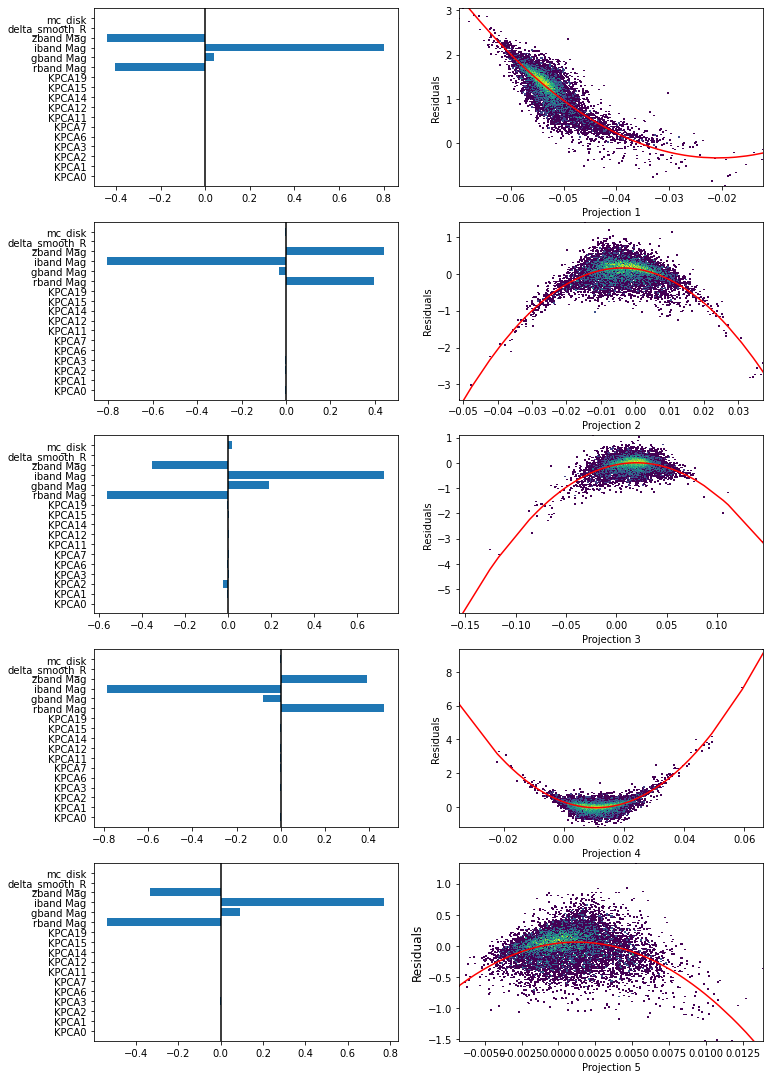

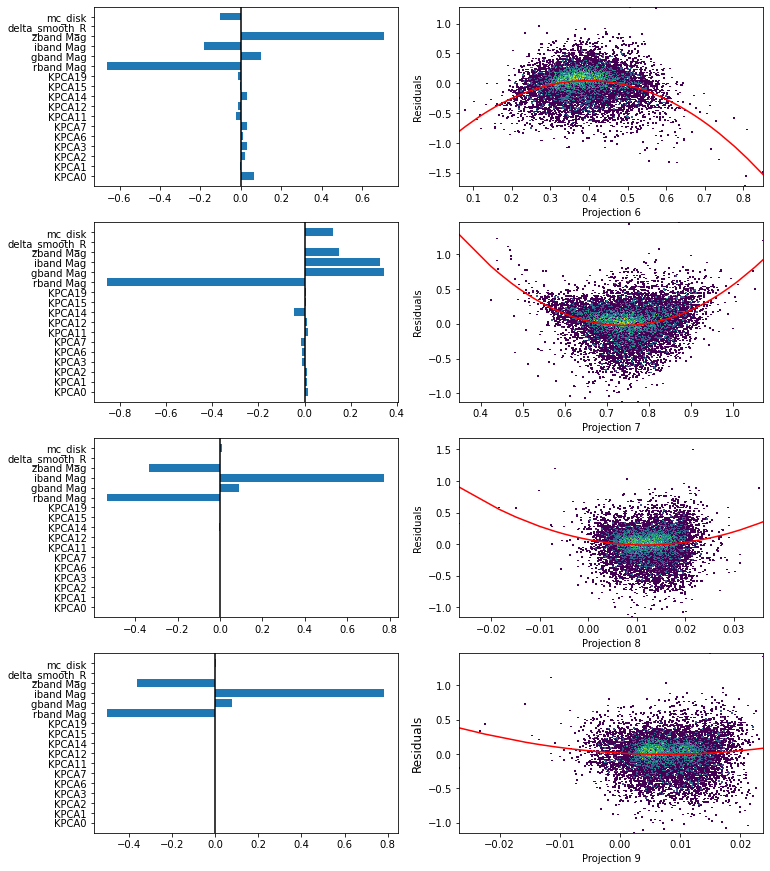

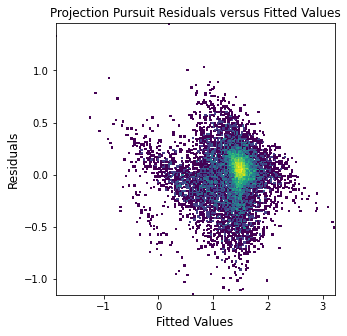

Plot of actual response versus fitted values


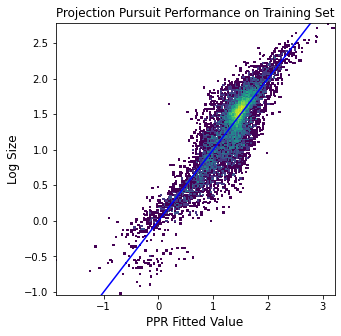

-----------------------------------------------
Performance on Test Set


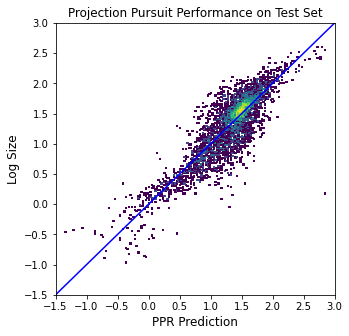

RMSE on test set: 0.234
RMSE on training set: 0.23


ProjectionPursuitRegressor(degree=2, fit_type='spline', r=9, random_state=0)

In [50]:
train_features = subinfo[subinfo['Set']==0][NEWpreds2]
train_labels = subinfo[subinfo['Set']==0][FullModelRespUse]

train_pixels = subinfo[subinfo['Set']==0]['pixelnum']

train_features = train_features.astype(float)

test_features = subinfo[subinfo['Set']>0][NEWpreds2]
test_labels = subinfo[subinfo['Set']>0][FullModelRespUse]

test_features = test_features.astype(float)

rtry = [3,4,5,6,7,8,9,10,11,12,13,14]

FullPPR(train_features, train_labels, test_features, test_labels,
            train_pixels, rtry, runname='OrigModel',PredsNames=NEWpreds2,degtry=[2])